## Modeling Strategied Assignment & Supervised ML_Mortgage --Yidan Li yl4357

## Table of Content
* [1.Data Preparation](#1)
 * [Drop highly missing/ single value/ not meaningful variables](#1.1)
 * [Binning and encoding missing and special values](#1.2)
 * [Encoding categorical and string variables](#1.3)
* [2.Feauture Selection](#2)
* [3.Random Forest Model with h2o](#3)
 * [Random Forest on small sample dataset (no resampling)](#3.1)
 * [Random Forest on entire dataset (no resampling)](#3.2)
 * [Random Forest on entire dataset (random undersampling)](#3.3)
 * [Random Forest on entire dataset (random oversampling)](#3.4)

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import plotly
import plotly.express as px
import seaborn as sns

In [2]:
df=pd.read_csv('/Users/liyidan/Desktop/Anomaly Detection/8. Supervised Learning/XYZloan_default_selected_vars.csv')
print(df.head(3))
print(df['loan_default'].value_counts())

   Unnamed: 0  Unnamed: 0.1  id  loan_default  AP001  AP002  AP003  AP004  \
0           0             1   1             1     31      2      1     12   
1           1             2   2             0     27      1      1     12   
2           2             3   3             0     33      1      4     12   

            AP005 AP006  ...  CD162  CD164  CD166  CD167   CD169   CD170  \
0  2017/7/6 10:21   ios  ...   13.0   13.0    0.0    0.0  1449.0  1449.0   
1  2017/4/6 12:51    h5  ...  -99.0  -99.0  -99.0  -99.0   -99.0   -99.0   
2  2017/7/1 14:11    h5  ...    3.0    2.0   33.0    0.0    33.0     0.0   

    CD172   CD173  MB005    MB007  
0  2249.0  2249.0    7.0  IPHONE7  
1   -99.0   -99.0    NaN      WEB  
2   143.0   110.0    8.0      WEB  

[3 rows x 89 columns]
0    64512
1    15488
Name: loan_default, dtype: int64


### 1. Data Preparation <a class="anchor" id="1"></a>

Explore the columns with missing value and their data types

In [3]:
null_cols=df.columns[df.isnull().any()]
print(null_cols)  #columns with NA values
print(df.select_dtypes(include=['float64','int64']).columns)  #numeric columns
print(df.select_dtypes(include=['object']).columns)  #categorical columns
#all columns with NA values are numeric

Index(['TD022', 'TD023', 'TD024', 'TD025', 'TD026', 'TD027', 'TD028', 'TD029',
       'TD044', 'TD048', 'TD051', 'TD054', 'TD055', 'TD061', 'TD062', 'PA022',
       'PA023', 'PA028', 'PA029', 'PA030', 'PA031', 'CD008', 'CD018', 'CD071',
       'CD072', 'CD088', 'CD100', 'CD101', 'CD106', 'CD107', 'CD108', 'CD113',
       'CD114', 'CD115', 'CD117', 'CD118', 'CD120', 'CD121', 'CD123', 'CD130',
       'CD131', 'CD132', 'CD133', 'CD135', 'CD136', 'CD137', 'CD152', 'CD153',
       'CD160', 'CD162', 'CD164', 'CD166', 'CD167', 'CD169', 'CD170', 'CD172',
       'CD173', 'MB005'],
      dtype='object')
Index(['Unnamed: 0', 'Unnamed: 0.1', 'id', 'loan_default', 'AP001', 'AP002',
       'AP003', 'AP004', 'AP007', 'AP008', 'AP009', 'TD001', 'TD002', 'TD005',
       'TD006', 'TD009', 'TD010', 'TD013', 'TD014', 'TD015', 'TD022', 'TD023',
       'TD024', 'TD025', 'TD026', 'TD027', 'TD028', 'TD029', 'TD044', 'TD048',
       'TD051', 'TD054', 'TD055', 'TD061', 'TD062', 'CR004', 'CR005', 'CR009',
      

#### Drop highly missing/ single value/ not meaningful variables <a class="anchor" id="1.1"></a>

In [4]:
#drop variables that are not meaningful for prediction
df=df.drop(['id','Unnamed: 0', 'Unnamed: 0.1'], axis=1)

In [5]:
#drop variables with only 1 unique value (including all missing variables)
for col in df.columns:
    if df[col].nunique() == 1:
        df.drop(col,inplace=True,axis=1)

In [6]:
#further examine columns with missing values
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent =100*df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Missing Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Missing Values', ascending=False).round(1)

        print ("The selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns
missing_values_table(df)

The selected dataframe has 73 columns.
There are 46 columns that have missing values.


,Missing Values,% of Missing Values
TD022,19598,24.5
TD023,7663,9.6
TD024,3694,4.6
MB005,2793,3.5
PA023,381,0.5
CD153,381,0.5
CD130,381,0.5
CD131,381,0.5
CD132,381,0.5
CD133,381,0.5


In [7]:
pd.options.display.max_columns = 100
df.describe()

,loan_default,AP001,AP002,AP003,AP004,AP007,AP008,AP009,TD001,TD002,TD005,TD006,TD009,TD010,TD013,TD014,TD015,TD022,TD023,TD024,CR004,CR005,CR009,CR015,CR017,CR018,CR019,PA022,PA023,PA028,PA029,PA030,PA031,CD008,CD018,CD071,CD072,CD088,CD100,CD101,CD106,CD107,CD108,CD113,CD114,CD115,CD117,CD118,CD120,CD121,CD123,CD130,CD131,CD132,CD133,CD135,CD136,CD137,CD152,CD153,CD160,CD162,CD164,CD166,CD167,CD169,CD170,CD172,CD173,MB005
count,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.00000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.00000,80000.000000,80000.000000,80000.000000,80000.000000,60402.000000,72337.000000,76306.000000,80000.000000,80000.000000,8.000000e+04,80000.000000,80000.000000,80000.000000,80000.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.00000,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,7.961900e+04,7.961900e+04,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.00000,79619.000000,79619.000000,77207.000000
mean,0.193600,31.706913,1.321813,2.014925,11.235413,3.30130,3.117200,0.727925,1.986962,0.706213,3.593037,1.345700,5.40600,2.020812,6.804737,2.603662,0.718775,17.120294,7.293156,5.541687,2.503450,1.595638,3.518711e+04,4.924750,5.234962,4.361112,6.199038,19.298811,14.828822,-36.738300,-42.407356,-74.438095,-48.404044,13470.599066,426.021427,34.502167,30.631106,40.050993,4.812457,0.586883,9.460857,3.010374,2.331253,-0.594243,1.176352,68.37697,48.368995,115.663070,83.749532,155.066228,113.074379,88.081815,81.524159,99.278916,108.111493,130.041146,120.280850,143.578153,1.360805e+04,1.366809e+04,6.911956,14.271694,11.773358,909.089313,810.786219,1732.693314,1539.33443,2513.226491,2229.606137,5.976272
std,0.395121,7.075070,0.467174,1.196806,2.212313,1.33655,1.306335,0.445031,1.807445,0.918347,2.799570,1.413362,4.02311,1.973988,5.128183,2.505840,0.882962,7.024737,7.395779,6.157043,1.117991,1.083602,6.359684e+04,1.094305,2.398870,2.498607,3.359354,39.705478,37.009374,100.731779,97.006168,74.146246,96.313406,13058.772406,373.327926,66.483870,61.899563,78.969397,43.655893,29.029802,61.423633,37.172491,35.030955,21.642171,23.311023,60.57446,46.932544,91.713711,69.112448,116.368152,86.765922,90.320004,88.529928,96.068148,96.793174,123.525977,120.935487,130.487618,1.905389e+04,1.935326e+04,28.007499,38.235012,33.270641,1379.553332,1245.044602,2441.503517,2172.71384,3404.975112,3005.615048,3.641814
min,0.000000,20.000000,1.000000,1.000000,3.000000,1.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,10.000000,0.000000,0.000000,1.000000,1.000000,0.000000e+00,2.000000,1.000000,0.000000,1.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.00000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-9.900000e+01,-9.900000e+01,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.00000,-99.000000,-99.000000,0.000000
25%,0.000000,27.000000,1.000000,1.000000,12.000000,2.00000,2.000000,0.000000,1.000000,0.000000,2.000000,0.000000,3.00000,1.000000,3.000000,1.000000,0.000000,10.000000,3.000000,2.000000,2.000000,1.000000,4.700000e+03,5.000000,3.000000,2.000000,3.000000,-1.000000,-1.000000,-98.000000,-98.000000,-98.000000,-98.000000,4769.500000,163.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,38.00000,28.000000,65.000000,48.000000,88.000000,65.000000,31.000000,26.000000,40.000000,48.000000

According to the variable description, variable PA022-CD173 should all be positive, but they all have negative values inside as shown in the above statistics, like -99, -1, which should be put in a new category, these variables will be included in the same category with NA values.

#### Binning and encoding missing and special values <a class="anchor" id="1.2"></a>

In [8]:
var_with_na=df.columns[df.isnull().any()]
var_with_na

Index(['TD022', 'TD023', 'TD024', 'PA022', 'PA023', 'PA028', 'PA029', 'PA030',
       'PA031', 'CD008', 'CD018', 'CD071', 'CD072', 'CD088', 'CD100', 'CD101',
       'CD106', 'CD107', 'CD108', 'CD113', 'CD114', 'CD115', 'CD117', 'CD118',
       'CD120', 'CD121', 'CD123', 'CD130', 'CD131', 'CD132', 'CD133', 'CD135',
       'CD136', 'CD137', 'CD152', 'CD153', 'CD160', 'CD162', 'CD164', 'CD166',
       'CD167', 'CD169', 'CD170', 'CD172', 'CD173', 'MB005'],
      dtype='object')

In [9]:
def binning(var):
    df[var].loc[df[var]==-99]=float('NaN')
    df[var].loc[df[var]==-98]=float('NaN')
    df[var].loc[df[var]==-1]=float('NaN')#convert all negative values to NA values
    df[var + '_bin'] = pd.qcut(df[var],10,duplicates='drop').values.add_categories("NoData")
    df[var + '_bin'] = df[var + '_bin'].fillna("NoData").astype(str) #assign NA values the category 'NoData'

import warnings
warnings.filterwarnings("ignore")   
    
for i in var_with_na:
    binning(i)

In [10]:
df.head(3)

,loan_default,AP001,AP002,AP003,AP004,AP005,AP006,AP007,AP008,AP009,TD001,TD002,TD005,TD006,TD009,TD010,TD013,TD014,TD015,TD022,TD023,TD024,CR004,CR005,CR009,CR015,CR017,CR018,CR019,PA022,PA023,PA028,PA029,PA030,PA031,CD008,CD018,CD071,CD072,CD088,CD100,CD101,CD106,CD107,CD108,CD113,CD114,CD115,CD117,CD118,...,CD172,CD173,MB005,MB007,TD022_bin,TD023_bin,TD024_bin,PA022_bin,PA023_bin,PA028_bin,PA029_bin,PA030_bin,PA031_bin,CD008_bin,CD018_bin,CD071_bin,CD072_bin,CD088_bin,CD100_bin,CD101_bin,CD106_bin,CD107_bin,CD108_bin,CD113_bin,CD114_bin,CD115_bin,CD117_bin,CD118_bin,CD120_bin,CD121_bin,CD123_bin,CD130_bin,CD131_bin,CD132_bin,CD133_bin,CD135_bin,CD136_bin,CD137_bin,CD152_bin,CD153_bin,CD160_bin,CD162_bin,CD164_bin,CD166_bin,CD167_bin,CD169_bin,CD170_bin,CD172_bin,CD173_bin,MB005_bin
0,1,31,2,1,12,2017/7/6 10:21,ios,3,3,1,1,1,4,1,5,1,14,2,2,10.0,9.0,6.0,2,1,35807,4,4,3,2,NaN,NaN,NaN,NaN,NaN,NaN,13840.0,172.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,57.0,48.0,95.0,...,2249.0,2249.0,7.0,IPHONE7,"(9.999, 15.0]","(6.0, 9.0]","(4.0, 6.0]",NoData,NoData,NoData,NoData,NoData,NoData,"(13171.0, 16592.0]","(152.0, 214.0]","(-0.001, 3.0]","(-0.001, 3.0]","(-0.001, 1.0]","(-0.001, 1.0]","(-0.001, 1.0]","(-0.001, 1.0]","(-0.001, 1.0]","(-0.001, 1.0]","(-0.001, 1.0]","(-0.001, 1.0]","(55.0, 65.0]","(47.0, 55.0]","(92.0, 107.0]","(68.0, 79.0]","(123.0, 144.0]","(91.0, 106.0]","(28.0, 43.0]","(52.0, 67.0]","(52.0, 68.0]","(45.0, 61.0]","(44.0, 66.0]","(77.0, 100.0]","(77.0, 99.0]","(9081.0, 11685.0]","(12444.0, 15706.0]","(7.0, 9.0]","(10.0, 13.0]","(11.0, 14.0]","(-0.001, 64.0]","(-0.001, 8.0]","(1098.0, 1498.0]","(1306.0, 1793.0]","(2216.0, 2936.7]","(1930.0, 2606.0]","(6.0, 7.0]"
1,0,27,1,1,12,2017/4/6 12:51,h5,5,4,0,2,0,3,1,3,1,3,2,0,15.0,6.0,0.0,3,1,7254,6,7,6,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,WEB,"(9.999, 15.0]","(3.0, 6.0]","(-0.001, 2.0]",NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData
2,0,33,1,4,12,2017/7/1 14:11,h5,4,2,0,2,1,4,1,5,1,9,1,2,15.0,9.0,2.0,2,2,30377,2,2,2,3,NaN,NaN,NaN,NaN,NaN,NaN,2454.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,13.0,20.0,...,143.0,110.0,8.0,WEB,"(9.999, 15.0]","(6.0, 9.0]","(-0.001, 2.0]",NoData,NoData,NoData,NoData,NoData,NoData,"(-0.001, 2536.0]","(-0.001, 89.0]","(-0.001, 3.0]","(-0.001, 3.0]","(-0.001, 1.0]","(-0.001, 1.0]","(-0.001, 1.0]","(-0.001, 1.0]","(-0.001, 1.0]","(-0.001, 1.0]","(-0.001, 1.0]","(-0.001, 1.0]","(-0.001, 26.0]","(-0.001, 19.0]","(-0.001, 45.0]","(-0.001, 33.0]","(-0.001, 62.0]","(-0.001, 45.0]","(-0.001, 12.0]","(-0.001, 10.0]","(-0.001, 22.0]","(-0.001, 27.0]","(-0.001, 21.0]","(-0.001, 18.0]","(-0.001, 32.0]","(3604.0, 5189.0]","(-0.001, 2558.1]","(-0.001, 1.0]","(2.0, 5.0]","(1.0, 4.0]","(-0.001, 64.0]","(-0.001, 8.0]","(-0.001, 68.0]","(-0.001, 7.0]","(-0.001, 172.0]","(105.0, 366.0]","(7.0, 9.0]"


#### Encode the binned variables using WOE Encoder 

In [11]:
def WOE(var):
    k = df[[var,'loan_default']].groupby(var)['loan_default'].agg(['count','sum']).reset_index()
    k.columns = [var,'count','default']
    k['non-default'] = k['count'] - k['default']
    k['default %'] = (k['default']/ k['default'].sum()).round(2)*100
    k['non-default %'] = (k['non-default'] / k['non-default'].sum()).round(2)*100
    k[var+'_WOE'] = np.log(k['default %'] / k['non-default %']).round(2)
    #when non-default %=0 0/0->nan replace with 0    x(x!=0)/0->inf/-inf replace with 1
    k[var] = k[var].fillna(0)
    k=k.replace([np.inf,-np.inf], 1)    
    return(k[[var,var+'_WOE']])

In [12]:
filter_col = [col for col in df if col.endswith('bin')]
for var in filter_col:
    df=pd.merge(df,WOE(var),on=var,how='left')

In [13]:
df.head(3)

,loan_default,AP001,AP002,AP003,AP004,AP005,AP006,AP007,AP008,AP009,TD001,TD002,TD005,TD006,TD009,TD010,TD013,TD014,TD015,TD022,TD023,TD024,CR004,CR005,CR009,CR015,CR017,CR018,CR019,PA022,PA023,PA028,PA029,PA030,PA031,CD008,CD018,CD071,CD072,CD088,CD100,CD101,CD106,CD107,CD108,CD113,CD114,CD115,CD117,CD118,...,CD170_bin,CD172_bin,CD173_bin,MB005_bin,TD022_bin_WOE,TD023_bin_WOE,TD024_bin_WOE,PA022_bin_WOE,PA023_bin_WOE,PA028_bin_WOE,PA029_bin_WOE,PA030_bin_WOE,PA031_bin_WOE,CD008_bin_WOE,CD018_bin_WOE,CD071_bin_WOE,CD072_bin_WOE,CD088_bin_WOE,CD100_bin_WOE,CD101_bin_WOE,CD106_bin_WOE,CD107_bin_WOE,CD108_bin_WOE,CD113_bin_WOE,CD114_bin_WOE,CD115_bin_WOE,CD117_bin_WOE,CD118_bin_WOE,CD120_bin_WOE,CD121_bin_WOE,CD123_bin_WOE,CD130_bin_WOE,CD131_bin_WOE,CD132_bin_WOE,CD133_bin_WOE,CD135_bin_WOE,CD136_bin_WOE,CD137_bin_WOE,CD152_bin_WOE,CD153_bin_WOE,CD160_bin_WOE,CD162_bin_WOE,CD164_bin_WOE,CD166_bin_WOE,CD167_bin_WOE,CD169_bin_WOE,CD170_bin_WOE,CD172_bin_WOE,CD173_bin_WOE,MB005_bin_WOE
0,1,31,2,1,12,2017/7/6 10:21,ios,3,3,1,1,1,4,1,5,1,14,2,2,10.0,9.0,6.0,2,1,35807,4,4,3,2,NaN,NaN,NaN,NaN,NaN,NaN,13840.0,172.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,57.0,48.0,95.0,...,"(1306.0, 1793.0]","(2216.0, 2936.7]","(1930.0, 2606.0]","(6.0, 7.0]",-0.04,0.18,0.10,-0.16,-0.13,-0.16,-0.12,-0.06,-0.13,0.00,0.11,-0.03,0.00,-0.05,-0.14,-0.11,-0.17,-0.13,-0.12,-0.14,-0.17,0.00,0.11,0.11,0.11,0.10,0.11,0.11,0.00,0.00,0.00,0.00,0.00,0.11,0.11,-0.11,0.00,-0.11,0.00,-0.05,-0.05,0.11,0.11,0.11,0.11,-0.13
1,0,27,1,1,12,2017/4/6 12:51,h5,5,4,0,2,0,3,1,3,1,3,2,0,15.0,6.0,0.0,3,1,7254,6,7,6,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NoData,NoData,NoData,NoData,-0.04,0.00,-0.17,-0.16,-0.13,-0.16,-0.12,-0.06,-0.13,-0.22,-0.22,-0.22,-0.22,-0.22,-0.22,-0.22,-0.22,-0.22,-0.22,-0.22,-0.22,-0.22,-0.22,-0.22,-0.22,-0.22,-0.22,-0.22,-0.22,-0.22,-0.22,-0.22,-0.22,-0.22,-0.22,-0.22,-0.22,-0.22,-0.22,-0.22,-0.22,-0.22,-0.22,-0.22,-0.22,-0.29
2,0,33,1,4,12,2017/7/1 14:11,h5,4,2,0,2,1,4,1,5,1,9,1,2,15.0,9.0,2.0,2,2,30377,2,2,2,3,NaN,NaN,NaN,NaN,NaN,NaN,2454.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,13.0,20.0,...,"(-0.001, 7.0]","(-0.001, 172.0]","(105.0, 366.0]","(7.0, 9.0]",-0.04,0.18,-0.17,-0.16,-0.13,-0.16,-0.12,-0.06,-0.13,0.11,0.11,-0.03,0.00,-0.05,-0.14,-0.11,-0.17,-0.13,-0.12,-0.14,-0.17,0.10,0.18,0.20,0.10,0.20,0.20,0.10,0.11,0.00,0.10,0.00,0.00,0.11,0.11,0.11,-0.13,-0.09,-0.07,-0.05,-0.05,-0.11,-0.22,-0.11,-0.11,-0.09


#### Encoding categorical and string variables (AP002, AP005, AP006, MB007)  <a class="anchor" id="1.3"></a>

In [14]:
#AP002 is gender, encode as 0/1
df['AP002']=df['AP002'].replace(2,0)

In [15]:
#extract year, month, day, hour, weekday from AP005
from datetime import datetime
df['AP005'] = pd.to_datetime(df['AP005'])
df['year'] = pd.DatetimeIndex(df['AP005']).year
df['month'] = pd.DatetimeIndex(df['AP005']).month
df['day'] = pd.DatetimeIndex(df['AP005']).day
df['hour'] = pd.DatetimeIndex(df['AP005']).hour
df['weekday'] = pd.DatetimeIndex(df['AP005']).dayofweek
df = pd.merge(df,WOE('year'),on='year',how='left')
df = pd.merge(df,WOE('month'),on='month',how='left')
df = pd.merge(df,WOE('day'),on='day',how='left')
df = pd.merge(df,WOE('hour'),on='hour',how='left')
df = pd.merge(df,WOE('weekday'),on='weekday',how='left')

In [16]:
#age data
df['AP001'].isnull().sum()
binning('AP001')
df = pd.merge(df,WOE('AP001_bin'),on='AP001_bin',how='left')

#### encoding categorical variables

In [17]:
#encode categorical variables ---AP006
print(df['AP006'].nunique())  #4 categories 
print(df.AP006.isna().sum()) #no missing value
df = pd.merge(df,WOE('AP006'),on='AP006',how='left')

4
0


In [18]:
#encode categorical variables  ---MB007
print(df['MB007'].nunique())  #112 categories ->WOE encoding
print(df.MB007.isna().sum())  #no missing value
df = pd.merge(df,WOE('MB007'),on='MB007',how='left')


112
0


In [19]:
df.isnull().sum()

loan_default        0
AP001               0
AP002               0
AP003               0
AP004               0
                 ... 
weekday_WOE         0
AP001_bin           0
AP001_bin_WOE       0
AP006_WOE           0
MB007_WOE        1683
Length: 179, dtype: int64

In [20]:
# df1=df1.replace([np.inf,-np.inf],1)
# df1=df1.round(2)
#There are still nans in hour_WOE and MB007_WOE ->replace with 0
df['hour_WOE'] = df['hour_WOE'].fillna(0)
df['MB007_WOE']=df['MB007_WOE'].fillna(0)

In [21]:
df.columns.tolist()

['loan_default',
 'AP001',
 'AP002',
 'AP003',
 'AP004',
 'AP005',
 'AP006',
 'AP007',
 'AP008',
 'AP009',
 'TD001',
 'TD002',
 'TD005',
 'TD006',
 'TD009',
 'TD010',
 'TD013',
 'TD014',
 'TD015',
 'TD022',
 'TD023',
 'TD024',
 'CR004',
 'CR005',
 'CR009',
 'CR015',
 'CR017',
 'CR018',
 'CR019',
 'PA022',
 'PA023',
 'PA028',
 'PA029',
 'PA030',
 'PA031',
 'CD008',
 'CD018',
 'CD071',
 'CD072',
 'CD088',
 'CD100',
 'CD101',
 'CD106',
 'CD107',
 'CD108',
 'CD113',
 'CD114',
 'CD115',
 'CD117',
 'CD118',
 'CD120',
 'CD121',
 'CD123',
 'CD130',
 'CD131',
 'CD132',
 'CD133',
 'CD135',
 'CD136',
 'CD137',
 'CD152',
 'CD153',
 'CD160',
 'CD162',
 'CD164',
 'CD166',
 'CD167',
 'CD169',
 'CD170',
 'CD172',
 'CD173',
 'MB005',
 'MB007',
 'TD022_bin',
 'TD023_bin',
 'TD024_bin',
 'PA022_bin',
 'PA023_bin',
 'PA028_bin',
 'PA029_bin',
 'PA030_bin',
 'PA031_bin',
 'CD008_bin',
 'CD018_bin',
 'CD071_bin',
 'CD072_bin',
 'CD088_bin',
 'CD100_bin',
 'CD101_bin',
 'CD106_bin',
 'CD107_bin',
 'CD108_bin

In [22]:
df1=df[['loan_default','AP002','AP003','AP004','AP007','AP008','AP009','TD001','TD002',
 'TD005','TD006','TD009','TD010','TD013','TD014','TD015','CR004','CR005','CR009',
 'CR015','CR017','CR018','CR019', 'TD022_bin_WOE','TD023_bin_WOE','TD024_bin_WOE','PA022_bin_WOE',
 'PA023_bin_WOE','PA028_bin_WOE','PA029_bin_WOE','PA030_bin_WOE','PA031_bin_WOE','CD008_bin_WOE',
 'CD018_bin_WOE', 'CD071_bin_WOE','CD072_bin_WOE','CD088_bin_WOE','CD100_bin_WOE','CD101_bin_WOE',
 'CD106_bin_WOE','CD107_bin_WOE','CD108_bin_WOE','CD113_bin_WOE','CD114_bin_WOE','CD115_bin_WOE',
 'CD117_bin_WOE','CD118_bin_WOE','CD120_bin_WOE','CD121_bin_WOE','CD123_bin_WOE','CD130_bin_WOE',
 'CD131_bin_WOE','CD132_bin_WOE','CD133_bin_WOE','CD135_bin_WOE','CD136_bin_WOE','CD137_bin_WOE',
 'CD152_bin_WOE','CD153_bin_WOE','CD160_bin_WOE','CD162_bin_WOE','CD164_bin_WOE','CD166_bin_WOE',
 'CD167_bin_WOE', 'CD169_bin_WOE','CD170_bin_WOE','CD172_bin_WOE','CD173_bin_WOE','MB005_bin_WOE',
 'year_WOE','month_WOE', 'day_WOE', 'hour_WOE','weekday_WOE','AP001_bin_WOE','AP006_WOE','MB007_WOE']]

In [23]:
#End of data preparation

### 2. Feature Selection <a class="anchor" id="2"></a>

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df1.drop(labels=['loan_default'], axis=1),
    df1['loan_default'],
    test_size=0.3,
    random_state=0)
X_train.shape, X_test.shape

((56000, 76), (24000, 76))

In [25]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
sel.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier())

In [26]:
selected_feat = X_train.columns[(sel.get_support())]
print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(selected_feat)))

total features: 76
selected features: 33


In [27]:
print(selected_feat)

Index(['AP003', 'AP007', 'AP008', 'TD001', 'TD005', 'TD006', 'TD009', 'TD010',
       'TD013', 'TD014', 'CR004', 'CR009', 'CR015', 'CR017', 'CR018', 'CR019',
       'TD023_bin_WOE', 'TD024_bin_WOE', 'CD071_bin_WOE', 'CD088_bin_WOE',
       'CD114_bin_WOE', 'CD117_bin_WOE', 'CD118_bin_WOE', 'CD120_bin_WOE',
       'CD121_bin_WOE', 'CD123_bin_WOE', 'CD160_bin_WOE', 'CD162_bin_WOE',
       'CD164_bin_WOE', 'MB005_bin_WOE', 'month_WOE', 'AP001_bin_WOE',
       'MB007_WOE'],
      dtype='object')


In [28]:
X=df1.drop(labels=['loan_default'], axis=1)

In [29]:
X_selected= X[selected_feat]

In [30]:
X_selected

,AP003,AP007,AP008,TD001,TD005,TD006,TD009,TD010,TD013,TD014,CR004,CR009,CR015,CR017,CR018,CR019,TD023_bin_WOE,TD024_bin_WOE,CD071_bin_WOE,CD088_bin_WOE,CD114_bin_WOE,CD117_bin_WOE,CD118_bin_WOE,CD120_bin_WOE,CD121_bin_WOE,CD123_bin_WOE,CD160_bin_WOE,CD162_bin_WOE,CD164_bin_WOE,MB005_bin_WOE,month_WOE,AP001_bin_WOE,MB007_WOE
0,1,3,3,1,4,1,5,1,14,2,2,35807,4,4,3,2,0.18,0.10,-0.03,-0.05,-0.17,0.11,0.11,0.11,0.10,0.11,0.00,-0.11,0.00,-0.13,-0.19,0.00,-0.13
1,1,5,4,2,3,1,3,1,3,2,3,7254,6,7,6,11,0.00,-0.17,-0.22,-0.22,-0.22,-0.22,-0.22,-0.22,-0.22,-0.22,-0.22,-0.22,-0.22,-0.29,0.13,0.12,-0.04
2,4,4,2,2,4,1,5,1,9,1,2,30377,2,2,2,3,0.18,-0.17,-0.03,-0.05,-0.17,0.18,0.20,0.10,0.20,0.20,-0.13,-0.09,-0.07,-0.09,-0.19,0.00,-0.04
3,4,5,5,0,0,0,0,0,1,1,2,0,5,7,7,8,-0.36,-0.51,-0.03,-0.05,-0.17,0.18,0.20,0.10,0.20,0.20,-0.13,-0.11,-0.22,-0.25,-0.19,0.00,0.34
4,1,4,4,2,2,1,2,1,2,1,4,0,6,8,7,11,-0.15,-0.17,-0.22,-0.22,-0.22,-0.22,-0.22,-0.22,-0.22,-0.22,-0.22,-0.22,-0.22,-0.29,-0.19,-0.11,-0.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79995,1,5,3,2,2,0,4,0,8,3,4,16716,5,5,5,6,-0.15,-0.07,0.11,-0.05,-0.17,0.10,0.10,0.20,0.11,0.11,0.00,0.00,-0.13,-0.25,0.07,0.00,0.34
79996,4,5,4,0,2,0,2,0,2,0,1,3388,5,7,4,5,-0.15,-0.17,0.00,0.00,0.00,-0.11,0.11,0.00,0.10,0.11,0.11,0.12,0.11,-0.11,-0.07,0.00,-0.13
79997,1,3,3,1,1,2,1,2,2,2,2,0,3,5,5,6,-0.15,-0.17,0.00,0.00,0.11,0.10,0.10,0.20,0.11,0.11,0.10,0.00,0.00,-0.41,-0.19,-0.12,0.41
79998,1,3,2,0,0,0,0,0,0,0,2,20200,4,5,5,5,-0.36,-0.51,-0.03,0.00,-0.17,0.12,0.10,0.20,0.11,0.11,-0.15,-0.09,-0.07,-0.11,0.07,0.00,0.00


In [31]:
df_selected=pd.concat([X_selected,df1['loan_default']],axis=1)

In [32]:
df_selected

,AP003,AP007,AP008,TD001,TD005,TD006,TD009,TD010,TD013,TD014,CR004,CR009,CR015,CR017,CR018,CR019,TD023_bin_WOE,TD024_bin_WOE,CD071_bin_WOE,CD088_bin_WOE,CD114_bin_WOE,CD117_bin_WOE,CD118_bin_WOE,CD120_bin_WOE,CD121_bin_WOE,CD123_bin_WOE,CD160_bin_WOE,CD162_bin_WOE,CD164_bin_WOE,MB005_bin_WOE,month_WOE,AP001_bin_WOE,MB007_WOE,loan_default
0,1,3,3,1,4,1,5,1,14,2,2,35807,4,4,3,2,0.18,0.10,-0.03,-0.05,-0.17,0.11,0.11,0.11,0.10,0.11,0.00,-0.11,0.00,-0.13,-0.19,0.00,-0.13,1
1,1,5,4,2,3,1,3,1,3,2,3,7254,6,7,6,11,0.00,-0.17,-0.22,-0.22,-0.22,-0.22,-0.22,-0.22,-0.22,-0.22,-0.22,-0.22,-0.22,-0.29,0.13,0.12,-0.04,0
2,4,4,2,2,4,1,5,1,9,1,2,30377,2,2,2,3,0.18,-0.17,-0.03,-0.05,-0.17,0.18,0.20,0.10,0.20,0.20,-0.13,-0.09,-0.07,-0.09,-0.19,0.00,-0.04,0
3,4,5,5,0,0,0,0,0,1,1,2,0,5,7,7,8,-0.36,-0.51,-0.03,-0.05,-0.17,0.18,0.20,0.10,0.20,0.20,-0.13,-0.11,-0.22,-0.25,-0.19,0.00,0.34,0
4,1,4,4,2,2,1,2,1,2,1,4,0,6,8,7,11,-0.15,-0.17,-0.22,-0.22,-0.22,-0.22,-0.22,-0.22,-0.22,-0.22,-0.22,-0.22,-0.22,-0.29,-0.19,-0.11,-0.04,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79995,1,5,3,2,2,0,4,0,8,3,4,16716,5,5,5,6,-0.15,-0.07,0.11,-0.05,-0.17,0.10,0.10,0.20,0.11,0.11,0.00,0.00,-0.13,-0.25,0.07,0.00,0.34,0
79996,4,5,4,0,2,0,2,0,2,0,1,3388,5,7,4,5,-0.15,-0.17,0.00,0.00,0.00,-0.11,0.11,0.00,0.10,0.11,0.11,0.12,0.11,-0.11,-0.07,0.00,-0.13,0
79997,1,3,3,1,1,2,1,2,2,2,2,0,3,5,5,6,-0.15,-0.17,0.00,0.00,0.11,0.10,0.10,0.20,0.11,0.11,0.10,0.00,0.00,-0.41,-0.19,-0.12,0.41,0
79998,1,3,2,0,0,0,0,0,0,0,2,20200,4,5,5,5,-0.36,-0.51,-0.03,0.00,-0.17,0.12,0.10,0.20,0.11,0.11,-0.15,-0.09,-0.07,-0.11,0.07,0.00,0.00,0


### Random Forest Model with h2o <a class="anchor" id="3"></a>

In [33]:
import h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "11.0.9" 2020-10-20 LTS; Java(TM) SE Runtime Environment 18.9 (build 11.0.9+7-LTS); Java HotSpot(TM) 64-Bit Server VM 18.9 (build 11.0.9+7-LTS, mixed mode)
  Starting server from /Users/liyidan/opt/anaconda3/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/42/vq68331n3z93l2vf5h3j7h780000gn/T/tmpq_i2kx65
  JVM stdout: /var/folders/42/vq68331n3z93l2vf5h3j7h780000gn/T/tmpq_i2kx65/h2o_liyidan_started_from_python.out
  JVM stderr: /var/folders/42/vq68331n3z93l2vf5h3j7h780000gn/T/tmpq_i2kx65/h2o_liyidan_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,04 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.3
H2O_cluster_version_age:,1 month and 9 days
H2O_cluster_name:,H2O_from_python_liyidan_gshi8p
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


In [34]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(
     df_selected,stratify=df_selected['loan_default'], test_size=0.30, random_state=1)

#### Random Forest on small sample (no resampling) <a class="anchor" id="3.1"></a>

In [35]:
train_smpl = train.sample(frac=0.1, random_state=1)
test_smpl = test.sample(frac=0.1, random_state=1)
train_hex1 = h2o.H2OFrame(train_smpl)
test_hex1 = h2o.H2OFrame(test_smpl)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [36]:
predictors=selected_feat.to_list()
target='loan_default'

In [37]:
from h2o.estimators.random_forest import H2ORandomForestEstimator
rf_v1 = H2ORandomForestEstimator(
        model_id = 'rf_v1',
        ntrees = 600,
        nfolds=10,
        min_rows=100,
        seed=1234)
rf_v1.train(predictors,target,training_frame=train_hex1)

drf Model Build progress: |███████████████████████████████████████████████| 100%


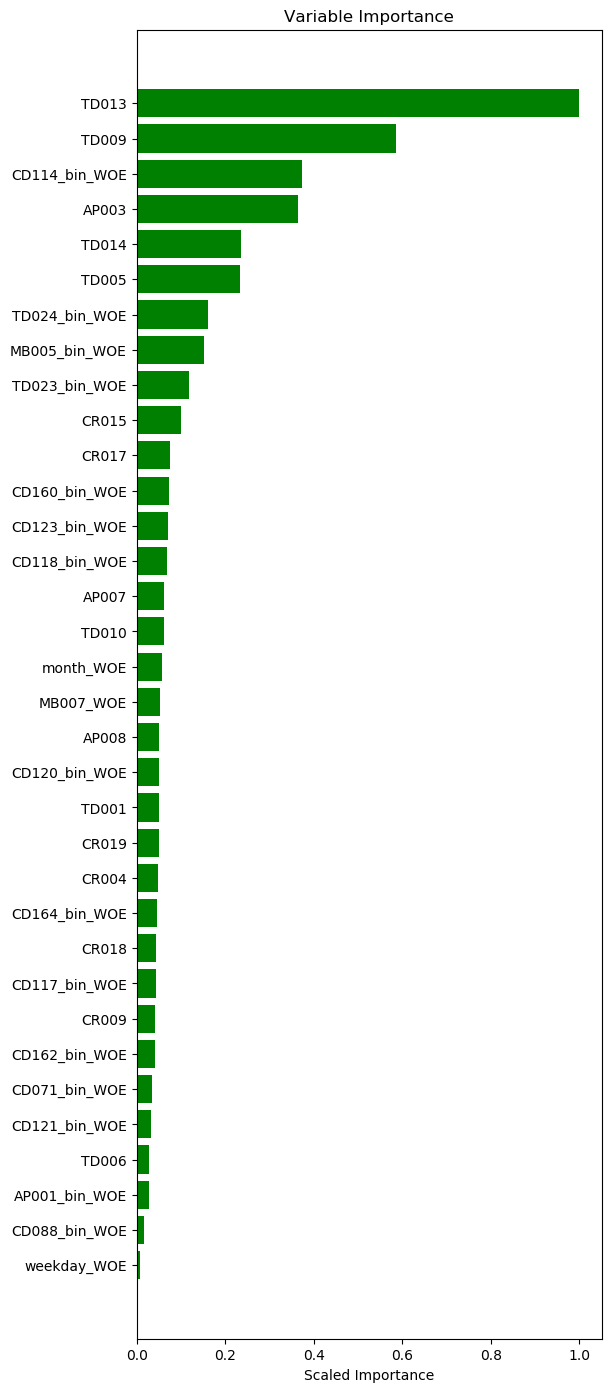

In [38]:
def VarImp(model_name):
    
    from sklearn.metrics import roc_curve,auc
    from sklearn.metrics import average_precision_score
    from sklearn.metrics import precision_recall_curve
    import matplotlib.pyplot as plt
    
    # plot the variable importance
    plt.rcdefaults()
    variables = model_name._model_json['output']['variable_importances']['variable']
    y_pos = np.arange(len(variables))
    fig, ax = plt.subplots(figsize = (6,len(variables)/2))
    scaled_importance = model_name._model_json['output']['variable_importances']['scaled_importance']
    ax.barh(y_pos,scaled_importance,align='center',color='green')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(variables)
    ax.invert_yaxis()
    ax.set_xlabel('Scaled Importance')
    ax.set_title('Variable Importance')
    plt.show()
    
VarImp(rf_v1)

In [39]:
predictions = rf_v1.predict(test_hex1)
print(predictions)
test_scores = test_hex1['loan_default'].cbind(predictions).as_data_frame()
print(test_scores)

drf prediction progress: |████████████████████████████████████████████████| 100%


predict
0.222635
0.121492
0.208262
0.131796
0.161867
0.152636
0.187967
0.304025
0.120529
0.11713



      loan_default   predict
0                0  0.222635
1                1  0.121492
2                0  0.208262
3                0  0.131796
4                0  0.161867
...            ...       ...
2395             0  0.323917
2396             0  0.132368
2397             0  0.087924
2398             1  0.119992
2399             0  0.151940

[2400 rows x 2 columns]


#### Gains Table

In [40]:
def createGains(model,test_data):
    predictions = model.predict(test_data)
    test_scores = test_data['loan_default'].cbind(predictions).as_data_frame()

    #sort on prediction (descending), add id, and decile for groups containing 1/10 of datapoints
    test_scores = test_scores.sort_values(by='predict',ascending=False)
    test_scores['row_id'] = range(0,0+len(test_scores))
    test_scores['decile'] = ( test_scores['row_id'] / (len(test_scores)/10) ).astype(int)
    #see count by decile
    test_scores.loc[test_scores['decile'] == 10]=9
    test_scores['decile'].value_counts()

    #create gains table
    gains = test_scores.groupby('decile')['loan_default'].agg(['count','sum'])
    gains.columns = ['count','actual']
    gains

    #add features to gains table
    gains['non_actual'] = gains['count'] - gains['actual']
    gains['cum_count'] = gains['count'].cumsum()
    gains['cum_actual'] = gains['actual'].cumsum()
    gains['cum_non_actual'] = gains['non_actual'].cumsum()
    gains['percent_cum_actual'] = (gains['cum_actual'] / np.max(gains['cum_actual'])).round(2)
    gains['percent_cum_non_actual'] = (gains['cum_non_actual'] / np.max(gains['cum_non_actual'])).round(2)
    gains['if_random'] = np.max(gains['cum_actual']) /10 
    gains['if_random'] = gains['if_random'].cumsum()
    gains['lift'] = (gains['cum_actual'] / gains['if_random']).round(2)
    gains['K_S'] = np.abs( gains['percent_cum_actual'] -  gains['percent_cum_non_actual'] ) * 100
    gains['gain']=(gains['cum_actual']/gains['cum_count']*100).round(2)
    gains = pd.DataFrame(gains)
    return(gains)

createGains(rf_v1,test_hex1)

drf prediction progress: |████████████████████████████████████████████████| 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,240,77,163,240,77,163,0.17,0.08,45.9,1.68,9.0,32.08
1,240,63,177,480,140,340,0.31,0.18,91.8,1.53,13.0,29.17
2,240,53,187,720,193,527,0.42,0.27,137.7,1.40,15.0,26.81
3,240,57,183,960,250,710,0.54,0.37,183.6,1.36,17.0,26.04
4,240,50,190,1200,300,900,0.65,0.46,229.5,1.31,19.0,25.00
5,240,34,206,1440,334,1106,0.73,0.57,275.4,1.21,16.0,23.19
6,240,39,201,1680,373,1307,0.81,0.67,321.3,1.16,14.0,22.20
7,240,32,208,1920,405,1515,0.88,0.78,367.2,1.10,10.0,21.09
8,240,35,205,2160,440,1720,0.96,0.89,413.1,1.07,7.0,20.37


#### ROC Curve and PR Curve

In [41]:
def ROC_AUC(my_result,df,target):
    from sklearn.metrics import roc_curve,auc
    from sklearn.metrics import average_precision_score
    from sklearn.metrics import precision_recall_curve
    import matplotlib.pyplot as plt

    # ROC
    y_actual = df[target].as_data_frame()
    y_pred = my_result.predict(df).as_data_frame()
#     print(y_pred[['p1']])
    fpr = list()
    tpr = list()
    roc_auc = list()
    fpr,tpr,_ = roc_curve(y_actual,y_pred)
    roc_auc = auc(fpr,tpr)
    
    # Precision-Recall
    average_precision = average_precision_score(y_actual,y_pred)

    print('')
    print('   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate')
    print('')
    print('	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy')
    print('')
    print('   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)')
    print('')
    
    # plotting
    plt.figure(figsize=(10,4))

    # ROC
    plt.subplot(1,2,1)
    plt.plot(fpr,tpr,color='darkorange',lw=2,label='ROC curve (aare=%0.2f)' % roc_auc)
    plt.plot([0,1],[0,1],color='navy',lw=3,linestyle='--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: AUC={0:0.4f}'.format(roc_auc))
    plt.legend(loc='lower right')

    # Precision-Recall
    plt.subplot(1,2,2)
    precision,recall,_ = precision_recall_curve(y_actual,y_pred)
    plt.step(recall,precision,color='b',alpha=0.2,where='post')
    plt.fill_between(recall,precision,step='post',alpha=0.2,color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0,1.05])
    plt.xlim([0.0,1.0])
    plt.title('Precision-Recall curve: PR={0:0.4f}'.format(average_precision))
    plt.show()


drf prediction progress: |████████████████████████████████████████████████| 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



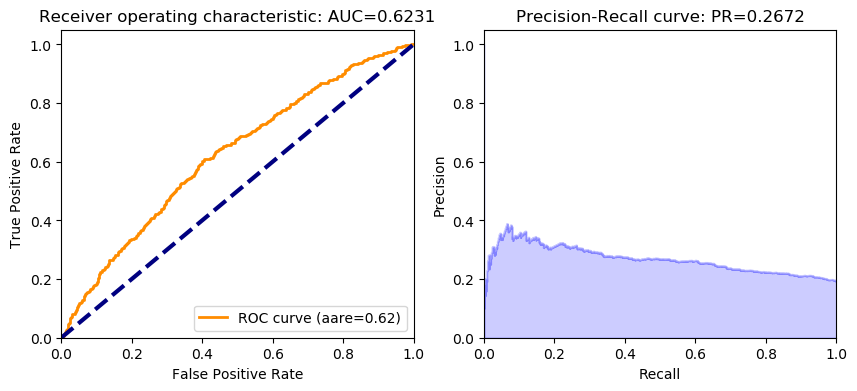

In [42]:
ROC_AUC(rf_v1,test_hex1,'loan_default')

#### Random Forest on entire dataset (no resampling) <a class="anchor" id="3.2"></a>

In [43]:
train_hex2 = h2o.H2OFrame(train)
test_hex2 = h2o.H2OFrame(test)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [44]:
predictors=selected_feat.to_list()
target='loan_default'

In [ ]:
from h2o.estimators.random_forest import H2ORandomForestEstimator

rf_v2 = H2ORandomForestEstimator(
        model_id = 'rf_v2',
        ntrees = 600,
        nfolds=10,
        min_rows=100,
        seed=1234)
rf_v2.train(predictors,target,training_frame=train_hex2)

drf Model Build progress: |██████████

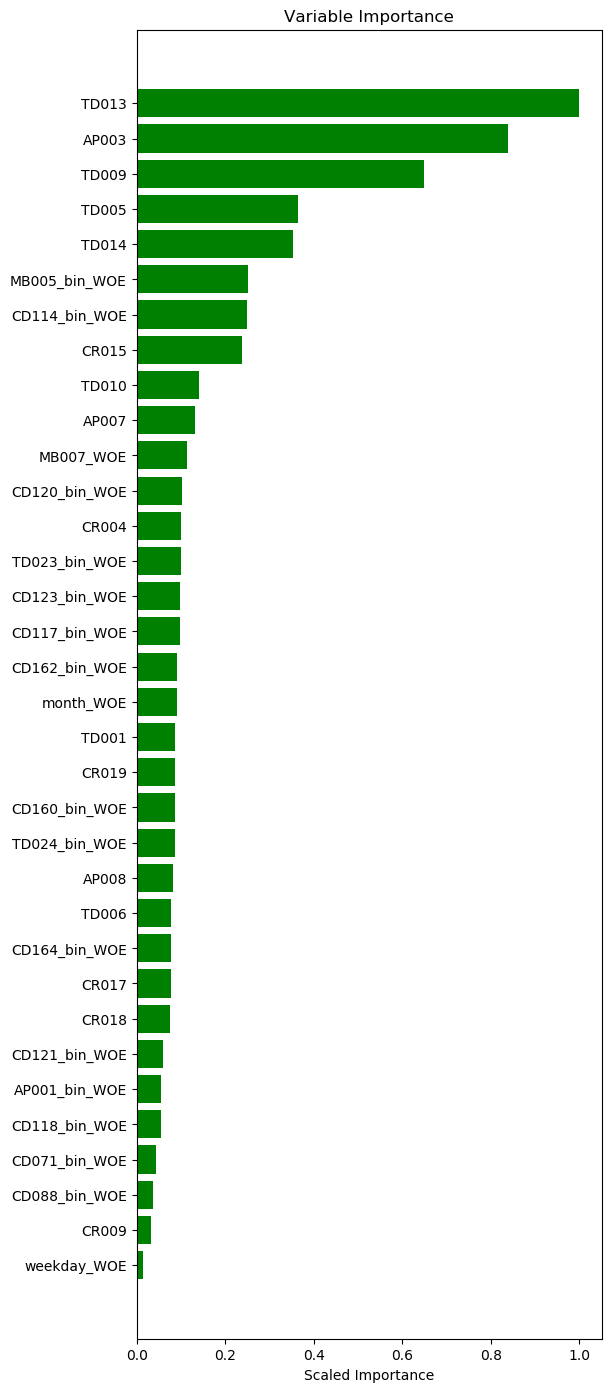

In [50]:
# feature importance
VarImp(rf_v2)

In [52]:
createGains(rf_v2,test_hex2)

drf prediction progress: |████████████████████████████████████████████████| 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,2400,877,1523,2400,877,1523,0.19,0.08,464.6,1.89,11.0,36.54
1,2400,691,1709,4800,1568,3232,0.34,0.17,929.2,1.69,17.0,32.67
2,2400,616,1784,7200,2184,5016,0.47,0.26,1393.8,1.57,21.0,30.33
3,2400,546,1854,9600,2730,6870,0.59,0.35,1858.4,1.47,24.0,28.44
4,2400,450,1950,12000,3180,8820,0.68,0.46,2323.0,1.37,22.0,26.50
5,2400,398,2002,14400,3578,10822,0.77,0.56,2787.6,1.28,21.0,24.85
6,2400,358,2042,16800,3936,12864,0.85,0.66,3252.2,1.21,19.0,23.43
7,2400,295,2105,19200,4231,14969,0.91,0.77,3716.8,1.14,14.0,22.04
8,2400,259,2141,21600,4490,17110,0.97,0.88,4181.4,1.07,9.0,20.79


drf prediction progress: |████████████████████████████████████████████████| 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



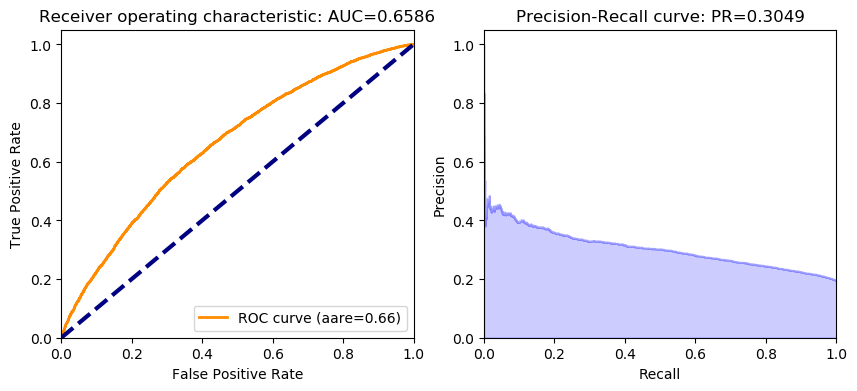

In [53]:
# ROC PR curves
ROC_AUC(rf_v2,test_hex2,'loan_default')

#### Random Forest on entire dataset (random undersampling) <a class="anchor" id="3.3"></a>

In [54]:
# define undersampling strategy
from imblearn.under_sampling import RandomUnderSampler
sampler = RandomUnderSampler(sampling_strategy=0.5)
X_under, y_under = sampler.fit_sample(train[selected_feat], train[['loan_default']])

In [55]:
train_random_under=pd.concat([X_under,y_under],axis=1)

In [56]:
train_random_under_hex3=h2o.H2OFrame(train_random_under)
test_hex3 = h2o.H2OFrame(test)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [57]:
predictors=selected_feat.to_list()
target='loan_default'

In [59]:
from h2o.estimators.random_forest import H2ORandomForestEstimator

rf_v3 = H2ORandomForestEstimator(
        model_id = 'rf_v3',
        ntrees = 300,
        nfolds=10,
        min_rows=100,
        seed=1234)
rf_v3.train(predictors,target,training_frame=train_random_under_hex3)

drf Model Build progress: |███████████████████████████████████████████████| 100%


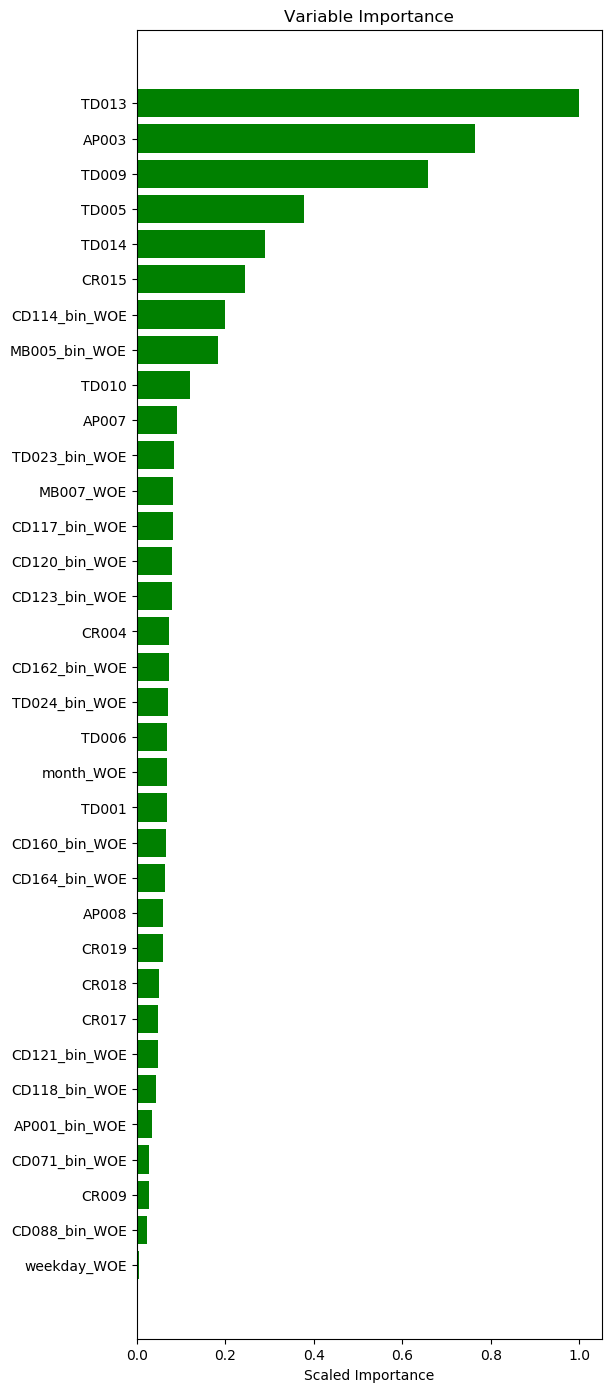

In [60]:
# feature importance
VarImp(rf_v3)

In [61]:
createGains(rf_v3,test_hex3)

drf prediction progress: |████████████████████████████████████████████████| 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,2400,855,1545,2400,855,1545,0.18,0.08,464.6,1.84,10.0,35.62
1,2400,697,1703,4800,1552,3248,0.33,0.17,929.2,1.67,16.0,32.33
2,2400,624,1776,7200,2176,5024,0.47,0.26,1393.8,1.56,21.0,30.22
3,2400,548,1852,9600,2724,6876,0.59,0.36,1858.4,1.47,23.0,28.38
4,2400,438,1962,12000,3162,8838,0.68,0.46,2323.0,1.36,22.0,26.35
5,2400,394,2006,14400,3556,10844,0.77,0.56,2787.6,1.28,21.0,24.69
6,2400,362,2038,16800,3918,12882,0.84,0.67,3252.2,1.20,17.0,23.32
7,2400,321,2079,19200,4239,14961,0.91,0.77,3716.8,1.14,14.0,22.08
8,2400,252,2148,21600,4491,17109,0.97,0.88,4181.4,1.07,9.0,20.79


drf prediction progress: |████████████████████████████████████████████████| 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



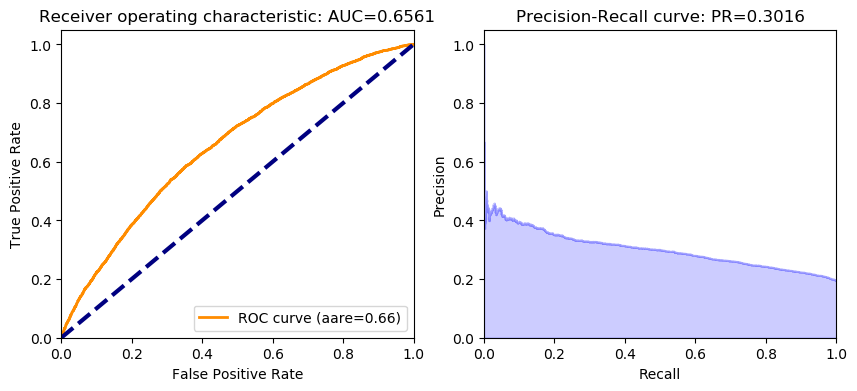

In [62]:
ROC_AUC(rf_v3,test_hex3,'loan_default')

#### Random Forest on entire dataset (random oversampling)  <a class="anchor" id="3.4"></a>

In [63]:
# define oversampling strategy
from imblearn.over_sampling import RandomOverSampler
sampler = RandomOverSampler(sampling_strategy=0.5)
X_over, y_over = sampler.fit_sample(train[selected_feat], train[['loan_default']])

In [64]:
train_random_over=pd.concat([X_over,y_over],axis=1)

In [65]:
train_random_over_hex4=h2o.H2OFrame(train_random_over)
test_hex4 = h2o.H2OFrame(test)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [66]:
predictors=selected_feat.to_list()
target='loan_default'

In [68]:
from h2o.estimators.random_forest import H2ORandomForestEstimator

rf_v4 = H2ORandomForestEstimator(
        model_id = 'rf_v4',
        ntrees = 300,
        nfolds=10,
        min_rows=100,
        seed=1234)
rf_v4.train(predictors,target,training_frame=train_random_over_hex4)

drf Model Build progress: |███████████████████████████████████████████████| 100%


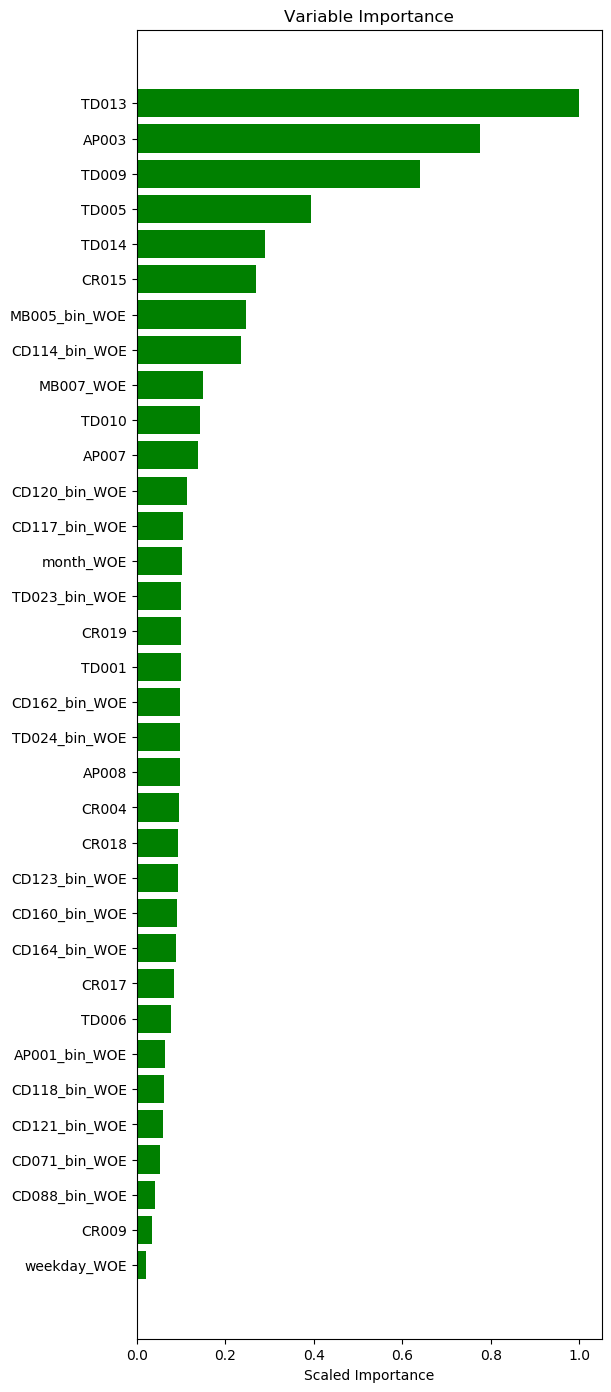

In [69]:
# feature importance
VarImp(rf_v4)

In [70]:
createGains(rf_v4,test_hex4)

drf prediction progress: |████████████████████████████████████████████████| 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,2400,875,1525,2400,875,1525,0.19,0.08,464.6,1.88,11.0,36.46
1,2400,690,1710,4800,1565,3235,0.34,0.17,929.2,1.68,17.0,32.60
2,2400,623,1777,7200,2188,5012,0.47,0.26,1393.8,1.57,21.0,30.39
3,2400,532,1868,9600,2720,6880,0.59,0.36,1858.4,1.46,23.0,28.33
4,2400,429,1971,12000,3149,8851,0.68,0.46,2323.0,1.36,22.0,26.24
5,2400,423,1977,14400,3572,10828,0.77,0.56,2787.6,1.28,21.0,24.81
6,2400,384,2016,16800,3956,12844,0.85,0.66,3252.2,1.22,19.0,23.55
7,2400,282,2118,19200,4238,14962,0.91,0.77,3716.8,1.14,14.0,22.07
8,2400,253,2147,21600,4491,17109,0.97,0.88,4181.4,1.07,9.0,20.79


drf prediction progress: |████████████████████████████████████████████████| 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



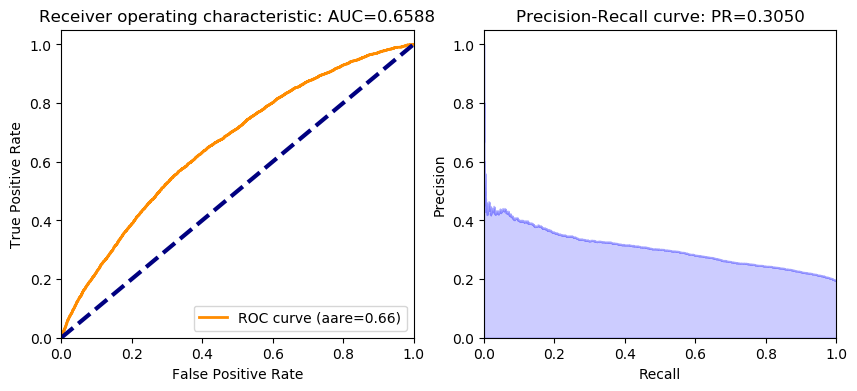

In [71]:
ROC_AUC(rf_v4,test_hex4,'loan_default')